In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import os
import numpy as np
from datetime import date

warnings.filterwarnings('ignore')

## washington

In [25]:
wa_reg = pd.read_csv(os.path.realpath(os.path.join(os.getcwd(), '..', 'Data/wa_new_ev_registrations.csv.gz')))
print(wa_reg.shape[0])
wa_reg = wa_reg[wa_reg['State of Residence'] == 'WA']
print(wa_reg.shape[0])
wa_reg = wa_reg[['Clean Alternative Fuel Vehicle Type', 'VIN (1-10)', 'Model Year',
       'Make', 'Model', 'New or Used Vehicle', 'Sale Price',
       'DOL Transaction Date', 'Transaction Type', 'Transaction Year', 'County', 'City', 'Postal Code',
       'Electric Range', 'Base MSRP', 'Sale Date', 'State of Residence', '2020 Census Tract']]

# using 'DOL Transaction Date' as date of registration
wa_reg['DOL Transaction Date'] = pd.to_datetime(wa_reg['DOL Transaction Date'])
wa_reg.head()

106730
106730


,Clean Alternative Fuel Vehicle Type,VIN (1-10),Model Year,Make,Model,New or Used Vehicle,Sale Price,DOL Transaction Date,Transaction Type,Transaction Year,County,City,Postal Code,Electric Range,Base MSRP,Sale Date,State of Residence,2020 Census Tract
0,Battery Electric Vehicle (BEV),5YJRE1A14A,2010,TESLA,Roadster,New,0,2010-07-28,Original Registration,2010,King,SEATTLE,98112.0,245,110950,June 25 2010,WA,5.303301e+10
1,Battery Electric Vehicle (BEV),5YJRE1A14A,2010,TESLA,Roadster,New,0,2010-03-17,Original Registration,2010,Clark,VANCOUVER,98664.0,245,110950,February 01 2010,WA,5.301104e+10
2,Battery Electric Vehicle (BEV),5YJRE1A14A,2010,TESLA,Roadster,New,0,2010-12-22,Original Registration,2010,King,REDMOND,98052.0,245,110950,December 11 2010,WA,5.303302e+10
3,Battery Electric Vehicle (BEV),5YJRE1A17A,2010,TESLA,Roadster,New,0,2010-12-22,Original Registration,2010,King,MERCER ISLAND,98040.0,245,110950,November 28 2010,WA,5.303302e+10
4,Battery Electric Vehicle (BEV),5YJRE1A18A,2010,TESLA,Roadster,New,0,2010-06-22,Original Registration,2010,King,KIRKLAND,98033.0,245,110950,May 31 2010,WA,5.303302e+10


In [69]:
wa_reg['County'].nunique()

39

In [19]:
wa_reg.to_csv(os.path.realpath(os.path.join(os.getcwd(), '..', 'Data/wa_new_ev_registrations.csv.gz')))

### registation for three most populous cities

In [26]:
# filter by zipcode in cities
zip_seattle = [98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98121, 98122, 98125, 98126, 98133, 98134, 98136, 98144, 98146, 98155, 98177, 98178, 98195, 98199]
zip_tacoma = [98402, 98403, 98404, 98405, 98406, 98407, 98408, 98409, 98416, 98418, 98421, 98422, 98444, 98445, 98465, 98466]
zip_spokane = [99201, 99202, 99203, 99204, 99205, 99207, 99208, 99212, 99217, 99218, 99223, 99224]

zip_city = []

for index, row in tqdm(wa_reg.iterrows()):
    if row['Postal Code'] in zip_seattle:
        zip_city.append('Seattle')
    elif row['Postal Code'] in zip_spokane:
        zip_city.append('Spokane')
    elif row['Postal Code'] in zip_tacoma:
        zip_city.append('Tacoma')
    else:
        zip_city.append(None)

wa_reg['City'] = zip_city

106730it [00:07, 14459.99it/s]


In [4]:
def wa_week_groupby(df, city=''):
    """
    groupby helper function
    """
    
    if city == '':
        pass
    else:
        df = df[df['City'] == city]

    df = df[['DOL Transaction Date']]
    df['sale'] = 1
    df['week'] = df['DOL Transaction Date'].dt.isocalendar().week
    df['month'] = df['DOL Transaction Date'].dt.month
    df['year'] = df['DOL Transaction Date'].dt.year

    df_week = df.groupby([df.year, df.month, df.week]).sum().reset_index()
    df_week['year-month-week'] = df_week['year'].astype(str) + '-' + df_week['month'].astype(str) + '-' + df_week['week'].astype(str)
    df_week['year-month'] = df_week['year'].astype(str) + '-' + df_week['month'].astype(str)

    df_week.rename(
        {'sale': 'weekly_new_reg'}, inplace=True, axis=1
    )
    df_week['cum_reg'] = df_week['weekly_new_reg'].cumsum()

    return df_week

In [27]:
wa_reg_grouped_week = wa_week_groupby(wa_reg)
seattle_reg_grouped_week = wa_week_groupby(wa_reg, city='Seattle')
tacoma_reg_grouped_week = wa_week_groupby(wa_reg, city='Tacoma')
spokane_reg_grouped_week = wa_week_groupby(wa_reg, city='Spokane')

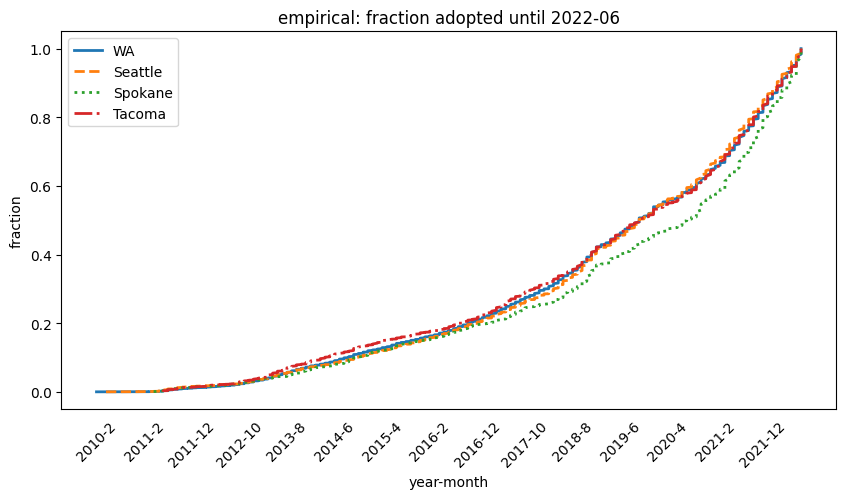

In [32]:
# normalization
wa_reg_grouped_week['cum_reg_norm'] = wa_reg_grouped_week['cum_reg'] / max(wa_reg_grouped_week['cum_reg'])
seattle_reg_grouped_week['cum_reg_norm'] = seattle_reg_grouped_week['cum_reg'] / max(seattle_reg_grouped_week['cum_reg'])
spokane_reg_grouped_week['cum_reg_norm'] = spokane_reg_grouped_week['cum_reg'] / max(spokane_reg_grouped_week['cum_reg'])
tacoma_reg_grouped_week['cum_reg_norm'] = tacoma_reg_grouped_week['cum_reg'] / max(tacoma_reg_grouped_week['cum_reg'])

plt.figure(figsize=(10, 5), dpi=100)
windows_size = 3 # rolling average of three months

reg_avg = wa_reg_grouped_week['cum_reg'].rolling(window=3).mean()

plt.plot(wa_reg_grouped_week['year-month'], wa_reg_grouped_week['cum_reg_norm'], '-', label='WA', linewidth=2)
plt.plot(seattle_reg_grouped_week['year-month'], seattle_reg_grouped_week['cum_reg_norm'], '--', label='Seattle', linewidth=2)
plt.plot(spokane_reg_grouped_week['year-month'], spokane_reg_grouped_week['cum_reg_norm'], ':' ,label='Spokane', linewidth=2)
plt.plot(tacoma_reg_grouped_week['year-month'], tacoma_reg_grouped_week['cum_reg_norm'], '-.' ,label='Tacoma', linewidth=2)

plt.legend()
plt.xticks(rotation = 45)
locs, labels = plt.xticks()
plt.title('empirical: fraction adopted until 2022-06')
plt.xlabel('year-month')
plt.ylabel('fraction')

for label in labels:
    label.set_visible(False)
for label in labels[0::10]:
    label.set_visible(True)
    
plt.tick_params(top=False, bottom=False)

plt.show()

## all registration aggregated by year-month-week

In [20]:
wa_reg_grouped_week = pd.read_csv(os.path.realpath(os.path.join(os.getcwd(), '..', 'Data/wa_pev_weekly_reg.csv')))
wa_reg_grouped_week['year-month-week'] = wa_reg_grouped_week['year'].astype(str) + '-' + wa_reg_grouped_week['month'].astype(str) + '-' + wa_reg_grouped_week['week'].astype(str)
wa_reg_grouped_week['cum_reg_norm'] = wa_reg_grouped_week['cum_reg'] / max(wa_reg_grouped_week['cum_reg'])
wa_reg_grouped_week.head()

,index,year,month,week,weekly_new_reg,year-month-week,year-month,cum_reg,cum_reg_norm
0,1,2010,12,51,4,2010-12-51,2010-12,21,0.000196
1,2,2011,1,1,1,2011-1-1,2011-1,22,0.000205
2,3,2011,1,2,1,2011-1-2,2011-1,23,0.000215
3,4,2011,1,3,0,2011-1-3,2011-1,23,0.000215
4,5,2011,1,4,4,2011-1-4,2011-1,27,0.000252


In [21]:
wa_reg_grouped_week.to_csv(os.path.realpath(os.path.join(os.getcwd(), '..', 'Data/wa_pev_weekly_reg.csv')))

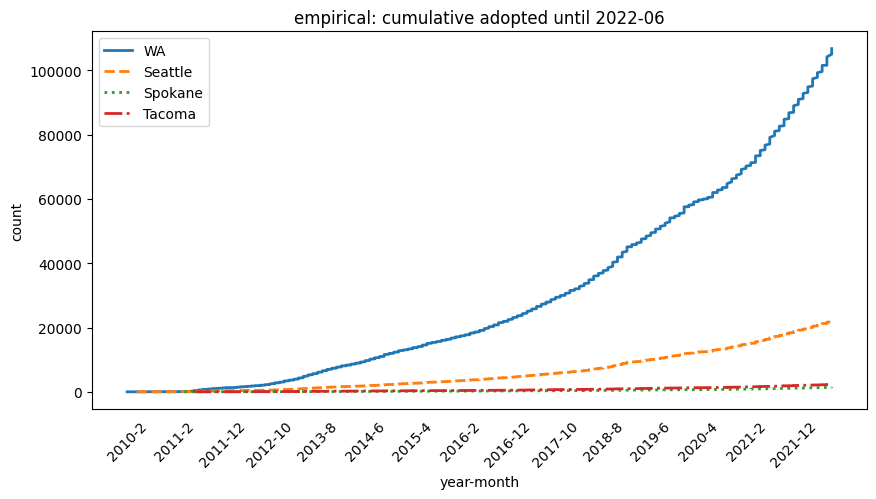

In [31]:
plt.figure(figsize=(10, 5), dpi=100)
windows_size = 3 # rolling average of three months

reg_avg = wa_reg_grouped_week['cum_reg'].rolling(window=3).mean()

plt.plot(wa_reg_grouped_week['year-month'], wa_reg_grouped_week['cum_reg'], '-', label='WA', linewidth=2)
plt.plot(seattle_reg_grouped_week['year-month'], seattle_reg_grouped_week['cum_reg'], '--', label='Seattle', linewidth=2)
plt.plot(spokane_reg_grouped_week['year-month'], spokane_reg_grouped_week['cum_reg'], ':' ,label='Spokane', linewidth=2)
plt.plot(tacoma_reg_grouped_week['year-month'], tacoma_reg_grouped_week['cum_reg'], '-.' ,label='Tacoma', linewidth=2)

plt.legend()
plt.xticks(rotation = 45)
locs, labels = plt.xticks()
plt.title('empirical: cumulative adopted until 2022-06')
plt.xlabel('year-month')
plt.ylabel('count')

for label in labels:
    label.set_visible(False)
for label in labels[0::10]:
    label.set_visible(True)
    
plt.tick_params(top=False, bottom=False)

plt.show()

## Future Projection

In [40]:
wa_weekly_cumsum_model = pd.read_csv('/Users/jarvis/CE253-EV-Adoption-Diffusion-Model-/Results/sum_adoption_5_percent.csv', index_col=0)
wa_reg_grouped_week = pd.read_csv('/Users/jarvis/CE253-EV-Adoption-Diffusion-Model-/Data/wa_pev_weekly_reg.csv')
wa_weekly_cumsum_model.head()

,week,number
0,0,0
1,1,229
2,2,229
3,3,229
4,4,229


In [45]:
wa_weekly_cumsum_model.tail()

,week,number
855,855,363494
856,856,365793
857,857,368093
858,858,370622
859,859,372921


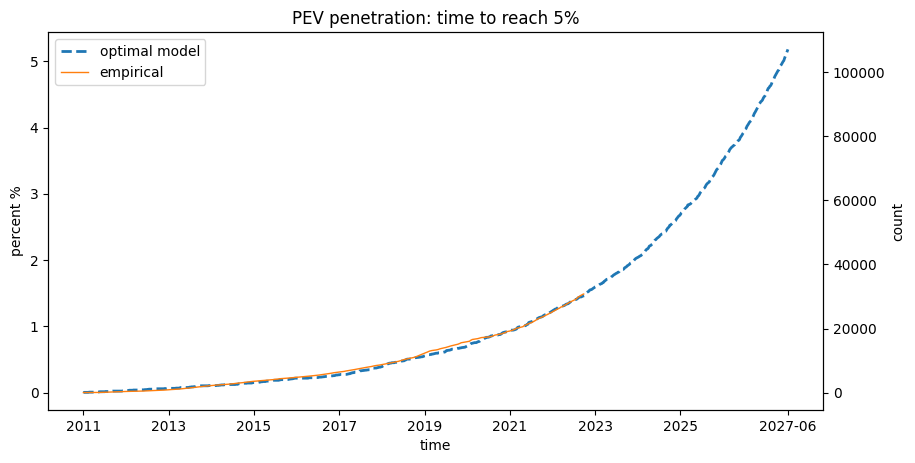

In [66]:
# plt.figure(figsize=(10, 5), dpi=100)
fig, ax = plt.subplots(figsize = (10, 5), dpi=100)
ax2 = ax.twinx()

ax.plot(wa_weekly_cumsum_model['week'], wa_weekly_cumsum_model['number']/7200000 * 100, '--', label='optimal model', linewidth=2)
ax.plot(wa_reg_grouped_week.index, wa_reg_grouped_week['cum_reg']/7200000 * 100, '-', label='empirical', linewidth=1)
ax2.plot(wa_reg_grouped_week.index, wa_reg_grouped_week['cum_reg'], '-', label='empirical', linewidth=0)

ax.legend(loc="upper left")
x_label_position = [0, 104, 208, 312, 416, 520, 624, 728, 859]
labels = [2011, 2013, 2015, 2017, 2019, 2021, 2023, 2025, '2027-06']
ax.set_xticks(x_label_position, labels)
ax2.set_xticks(x_label_position, labels)
plt.title('PEV penetration: time to reach 5%')
ax.set_xlabel('time')
ax.set_ylabel('percent %')
ax2.set_ylabel('count')

plt.show()

## Critical Mass: Empirical Sampling

In [68]:
num_adopted_lst = []

for i in np.arange(10):
    model_output = pd.read_csv('/Users/jarvis/CE253-EV-Adoption-Diffusion-Model-/Results/output_0.csv', index_col=0)
    num_adopted = sum(model_output[model_output['week'] == 609]['number'])
    num_adopted_lst.append(num_adopted)

print(np.average(num_adopted_lst) * 0.004349443575683363)

454.46900977957887


In [73]:
wa_reg_sample = wa_reg.sample(454)
wa_reg_sample = wa_reg_sample[['DOL Transaction Date', 'County', 'Postal Code']]
wa_reg_sample['week'] = wa_reg_sample['DOL Transaction Date'].apply(lambda date: int((pd.to_datetime(date) - pd.to_datetime('2011/01/01')) / np.timedelta64(1, 'W')))

In [75]:
wa_reg_sample.sort_values('week').tail()

,DOL Transaction Date,County,Postal Code,week
91372,2022-08-19,King,98112.0,606
105730,2022-08-16,King,98148.0,606
90347,2022-08-25,Pierce,98406.0,607
91218,2022-08-25,King,98031.0,607
91846,2022-08-30,King,98101.0,608


In [79]:
for i in np.arange(20):
    wa_reg_sample = wa_reg[wa_reg['DOL Transaction Date'] > '2011-01-01'].sample(454)
    wa_reg_sample = wa_reg_sample[['DOL Transaction Date', 'County', 'Postal Code']]
    wa_reg_sample['Postal Code'] = wa_reg_sample['Postal Code'].astype(int)
    wa_reg_sample['week'] = wa_reg_sample['DOL Transaction Date'].apply(lambda date: int((pd.to_datetime(date) - pd.to_datetime('2011/01/01')) / np.timedelta64(1, 'W')))
    wa_reg_sample = wa_reg_sample.sort_values('week')
    wa_reg_sample.reset_index(drop=True).to_csv(f'../Results/emp_adoption_sample/wa_reg_sample_{i}.csv')

In [99]:
wa_reg_sample = pd.read_csv(f'../Results/emp_adoption_sample/wa_reg_sample_{14}.csv', index_col=0)
wa_reg_sample['DOL Transaction Date'] = pd.to_datetime(wa_reg_sample['DOL Transaction Date'])
wa_reg_county = wa_reg_sample[wa_reg_sample['County'] == 'Clallam'].reset_index(drop=True)
wa_reg_county = wa_reg_county.sort_values(by='DOL Transaction Date')
total_reg = int(wa_reg_county.shape[0])
if total_reg == 0:
    pass
else:
    week_to_cm = wa_reg_county.loc[round(total_reg * cm_tresh), 'week']

KeyError: 0

In [100]:
wa_reg_county

,DOL Transaction Date,County,Postal Code,week


In [104]:
cm_tresh = 0.135
wa_county_cm_avg = pd.DataFrame(columns=['county', 'total_reg_avg', 'week_to_cm_avg'])
for county in wa_reg_sample['County'].unique():
    total_reg_lst = []
    week_to_cm_lst = []
    for i in np.arange(20):
        wa_reg_sample = pd.read_csv(f'../Results/emp_adoption_sample/wa_reg_sample_{i}.csv', index_col=0)
        wa_reg_sample['DOL Transaction Date'] = pd.to_datetime(wa_reg_sample['DOL Transaction Date'])
        wa_reg_county = wa_reg_sample[wa_reg_sample['County'] == county].reset_index(drop=True)
        wa_reg_county = wa_reg_county.sort_values(by='DOL Transaction Date')
        total_reg = int(wa_reg_county.shape[0])

        if total_reg == 0:
            pass
        else:
            week_to_cm = wa_reg_county.loc[round(total_reg * cm_tresh), 'week']
            total_reg_lst.append(total_reg)
            week_to_cm_lst.append(week_to_cm)
    

    wa_county_cm_avg = wa_county_cm_avg.append(
        {'county': county, 'total_reg_avg': round(np.average(total_reg_lst)), 'week_to_cm_avg': round(np.average(week_to_cm_lst))}, ignore_index = True
        )
    wa_county_cm_avg = wa_county_cm_avg.sort_values('week_to_cm_avg')

In [105]:
wa_county_cm_avg.to_csv('../Results/wa_county_cm_avg.csv')

,county,total_reg_avg,week_to_cm_avg
0,King,263,234
1,Snohomish,47,246
2,Kitsap,14,247
3,Pierce,32,248
4,Whatcom,9,262
5,Clark,22,265
6,Thurston,16,268
7,Clallam,2,274
8,Spokane,9,328
9,Skagit,5,357
